### Football match prediction
___

#### Summary

This notebook tries to predict the outcome of football matches using historical match data. The test season is the 2019/2020 English Premier League (the prior 10 seasons across the top 5 European leagues are used for training).

#### Index

1. [Preamble](#Preamble) <br>
2. [EDA](#EDA) <br>
3. [Feature Eng](#Feature-Eng)
4. [Model](#Model)
5. [Tuning](#Tuning)
6. [Predictions](#Predictions)
7. [Evaluate](#Evaluate)

#### Preamble
___

Library imports take place here (there are some scikit learn and keras functions that are imported under the hood in the modules - check the code of each module to see). Versions can be found in the requirements.txt. The project modules are all in the common folder and are broken down by functionality (general data functions, feature engineering and the model).

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import glob
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
import shap

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# modules
import common.data_methods as data_methods
import common.model as model
import common.feature_eng as feature_eng

Using TensorFlow backend.


#### EDA
___

To get the match result data go to [this site](https://www.football-data.co.uk/data.php). Here you will find multiple seasons of football data covering pretty much all the leagues in the world. The data mainly consists of match results, total shots and betting odds. Download the data and store in folder within the project, then pass the data directory as an argument to the function below (I have not included the raw data on the repo as its bad etiquette to do so!). Don't worry about subfolders within the data folder as the function searches all subfolders.

In [3]:
# list of dataframes for each season
seasons = data_methods.load_indiv_seasons(data_directory = os.getcwd() + "\data\matches",
                                cols = ['Div','Date','HomeTeam','AwayTeam','FTR','FTHG','FTAG','HS','AS','HST','AST','B365H','B365A','B365D'])

Explore the data! Here check for duplicate matches in each season, and then combine all the seasons and plot a correlation heatmap

In [4]:
# check if there are duplicate matches in any season
[(len(season[~season.duplicated()])/len(season)) for season in seasons]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

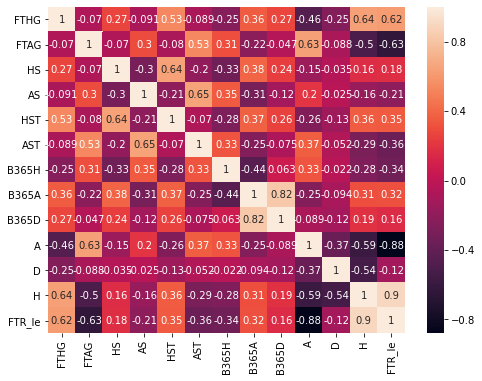

In [5]:
# heatmap for correlations
all_matches = pd.concat(seasons)
corr = all_matches.corr()
_=plt.figure(figsize=(8,6))
_=sns.heatmap(corr,annot=True)

#### Feature Eng
___

I want to engineer some predictive features based on my knowledge of football (and having seen that weak correlations that exist in the raw dataset). The aim of the project is to predict the outcome of football matches. Therefore my features must contribute to this aim. Some of the key things that contribute a match result are the current performance of the team (i.e the teams form) and the strength of the team (can use the league position as a proxy for this). It is also important to have seperate features for home and away as a teams performance can change dramatically based on where they play.

In total there are 12 predictive features (NB Each season is treated independently). These are as follows:

- __HP__: cumulative points accrued during the season at home
- __HGD_rm__: goal difference at home, rolling mean
- __HST%_rm__: shots on target percentage at home, rolling mean
- __HSTC%_rm__: shots on target conceded percentage at home, rolling mean
- __HGS%_rm__: goals scored per shot at home, rolling mean
- __HGSC%_rm__: goals conceded per shot at home, rolling mean
- __AP__: cumulative points accrued during the season away
- __AGD_rm__: goal difference away, rolling mean
- __AST%_rm__: shots on target percentage away, rolling mean
- __ASTC%_rm__: shots on target conceded percentage away, rolling mean
- __AGS%_rm__: goals scored per shot away, rolling mean
- __AGSC%_rm__: goals conceded per shot away, rolling mean

I have used rolling means as predictive features to represent a teams form. __Its vitally important to train the model on features that would be available prior to the match__. It would be no use to train using a teams match data prior to the match taking place! I have selected 5 games as the sliding window (could explore using another value). An extension here would be to use some more sophisticated time series techniques to account for form, such as LSTMs.


In [8]:
# feature engineered data with a selected rolling window - this takes 2mins to run
processed_data = feature_eng.master_feature_builder(seasons,5)

In [42]:
processed_data.head()

,Div,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HST,...,HGSC%_rm,AG_rm,AC_rm,AGD_rm,AST%_rm,ASTC%_rm,AGS%_rm,AGSC%_rm,HP,AP
0,E0,2009-08-15,Aston Villa,Wigan,A,0.0,2.0,11.0,14.0,5.0,...,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000,0.000000,0.0,0.0
1,E0,2009-08-30,Aston Villa,Fulham,H,2.0,0.0,9.0,6.0,4.0,...,0.140000,0.0,0.0,0.0,0.3300,0.250000,0.110,0.000000,0.0,3.0
2,E0,2009-09-19,Aston Villa,Portsmouth,H,2.0,0.0,7.0,17.0,5.0,...,0.070000,0.0,0.0,0.0,0.4400,0.700000,0.055,0.160000,3.0,0.0
3,E0,2009-10-05,Aston Villa,Man City,D,1.0,1.0,12.0,9.0,6.0,...,0.046667,0.0,0.0,0.0,0.6300,0.533333,0.210,0.063333,6.0,6.0
4,E0,2009-10-17,Aston Villa,Chelsea,H,2.0,1.0,7.0,21.0,5.0,...,0.062500,0.0,0.0,0.0,0.4775,0.525000,0.125,0.175000,7.0,9.0


Now we look at the distributions of each of the features.

In [20]:
# input and output columns of interest
y_cols = ['FTR','FTR_le','D', 'H', 'A']
x_cols = ['HP','HGD_rm','HST%_rm', 'HSTC%_rm','HGS%_rm', 'HGSC%_rm','AP','AGD_rm','AST%_rm', 'ASTC%_rm', 'AGS%_rm', 'AGSC%_rm']

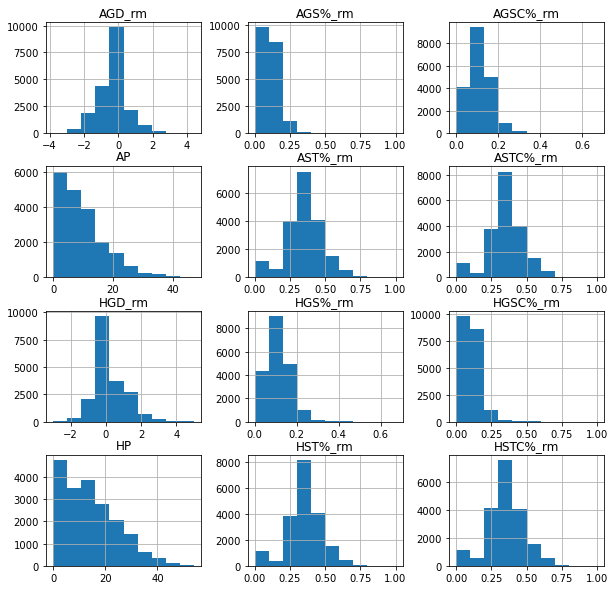

In [21]:
_=processed_data[x_cols].hist(figsize=(10,10))

Seperate out the train and test sets and then normalise the both the train and test input features seperately (this is important because no information from the test set can leak into the training data). The output features for both train and test do not need to be scaled as they are binary

In [106]:
importlib.reload(data_methods)

<module 'common.data_methods' from 'C:\\Users\\s0804424\\OneDrive - University of Edinburgh\\Documents-ENG-5216\\Analytics\\football\\result-predict\\result-predict\\common\\data_methods.py'>

In [107]:
train_x, train_y, test_x, test_y = data_methods.train_test_split(processed_data,
                                                    x_cols,y_cols,
                                                    scaler= StandardScaler())

KeyError: "['B365A', 'B365H', 'B365D'] not in index"

In [105]:
test_y

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,FTR_le,D,H,A
3800,2019-08-09,Liverpool,Norwich,4.0,1.0,H,2,0,1,0
3801,2019-08-24,Liverpool,Arsenal,3.0,1.0,H,2,0,1,0
3802,2019-09-14,Liverpool,Newcastle,3.0,1.0,H,2,0,1,0
3803,2019-10-05,Liverpool,Leicester,2.0,1.0,H,2,0,1,0
3804,2019-10-27,Liverpool,Tottenham,2.0,1.0,H,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...
19570,2020-01-03,Valladolid,Leganes,2.0,2.0,D,1,1,0,0
19571,2020-01-26,Valladolid,Real Madrid,0.0,1.0,A,0,0,0,1
19572,2020-02-08,Valladolid,Villarreal,1.0,1.0,D,1,1,0,0
19573,2020-02-23,Valladolid,Espanol,2.0,1.0,H,2,0,1,0


#### Model
___

A deep neural network is built using the Keras sequential class. The NeuralNet class can be found in the model module and contains methods to build a model, do grid search cross validation, fit a model and make predictions of classes and probabilities. The training data is all seasons prior to the 2019/20 season (which is the test season).

In [78]:
# create a neural net object, output dimensions are 3 for home win, away win and draw
nn = model.NeuralNet(train_x,train_y,
                     test_x,test_y,
                     input_dim=train_x.shape[1],
                     output_dim=3)

In [66]:
print(train_x.shape,train_y.shape)

(18258, 12) (18258, 5)


#### Tuning
___

Tuning the model involves finding the optimum hyperparameters that give the highest model accuracy. Scikit learns Grid search cross validation method is used. The baseline model (to evaluate our tuning) is from this paper 

In [91]:
parameters = {'batch_size':[64,128],
             'nb_epoch':[100],
              'hn1':[32,16],
             'hn2':[16,8]}

The score to evaluate the model is weighted precision as this is more important to me in the context of betting than other scores such as accuracy and f1.

In [92]:
from sklearn.metrics import make_scorer, precision_score
scorer = make_scorer(precision_score, average = 'weighted')

In [93]:
gridsearch = nn.gridCV(parameters=parameters,
                      scoring=scorer)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [94]:
gridsearch.best_score_

0.44542885650231073

In [95]:
gridsearch.best_params_

{'batch_size': 64, 'hn1': 32, 'hn2': 16, 'nb_epoch': 100}

#### Predictions
___

Fit the final model using the best parameters from the grid search. Then make predictions using the 2019/20 EPL data and print the classification report

In [96]:
final_classifier = nn.build_classifier(
                                       hn1 = gridsearch.best_params_['hn1'],
                                       hn2 = gridsearch.best_params_['hn2'])

In [97]:
fitted_classifier = nn.fit_classifier(epochs = gridsearch.best_params_['nb_epoch'],
                                         batch_size = gridsearch.best_params_['batch_size'],
                                          compiled_model = final_classifier)

In [102]:
all_preds = nn.predictions(fitted_classifier)

In [104]:
all_preds

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,FTR_le,D,H,A,PClass,PA,PD,PH
0,2019-08-09,Liverpool,Norwich,4.0,1.0,H,2,0,1,0,2,0.314104,0.221201,0.464695
1,2019-08-24,Liverpool,Arsenal,3.0,1.0,H,2,0,1,0,2,0.231625,0.247717,0.520658
2,2019-09-14,Liverpool,Newcastle,3.0,1.0,H,2,0,1,0,2,0.188471,0.268017,0.543512
3,2019-10-05,Liverpool,Leicester,2.0,1.0,H,2,0,1,0,2,0.171715,0.200265,0.628021
4,2019-10-27,Liverpool,Tottenham,2.0,1.0,H,2,0,1,0,2,0.131974,0.163419,0.704607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2020-01-03,Valladolid,Leganes,2.0,2.0,D,1,1,0,0,2,0.105188,0.344665,0.550147
1313,2020-01-26,Valladolid,Real Madrid,0.0,1.0,A,0,0,0,1,0,0.442946,0.338556,0.218499
1314,2020-02-08,Valladolid,Villarreal,1.0,1.0,D,1,1,0,0,0,0.572098,0.209353,0.218549
1315,2020-02-23,Valladolid,Espanol,2.0,1.0,H,2,0,1,0,2,0.311337,0.287441,0.401222


In [103]:
prem_preds = all_preds[all_preds['Div']=='E0']

KeyError: 'Div'

In [99]:
print(classification_report(y_true=nn.predictions(fitted_classifier)['FTR_le'],
                            y_pred =nn.predictions(fitted_classifier)['PClass'],
                            target_names=['A','D','H']))

              precision    recall  f1-score   support

           A       0.44      0.34      0.38       401
           D       0.25      0.05      0.08       324
           H       0.49      0.79      0.60       592

    accuracy                           0.47      1317
   macro avg       0.39      0.39      0.36      1317
weighted avg       0.42      0.47      0.41      1317



#### Evaluate
___

To interprete the outputs of the model, Shapley values are used. They originate in game theory and show the marginal contribution of a feature to the overall predictive capability of the model. Plotting the Shapley values allows for the relative importance of the features to be seen visually.
It is clear in this instance that the features HP (cumulative points gathered at home) and AP (cumulative points gathered away from home) are significant contributors to the predictive capability of the model.

In [100]:
# shap library
explainer = shap.DeepExplainer(fitted_classifier,test_x)
shap_values = explainer.shap_values(test_x)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


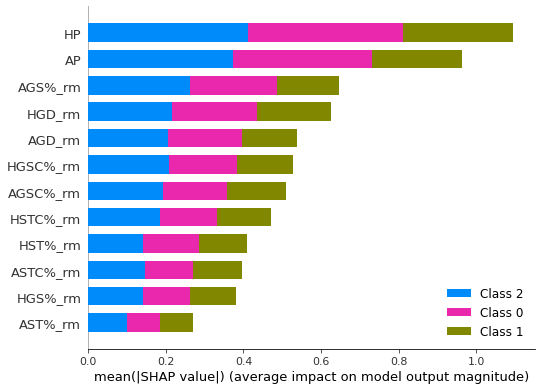

In [101]:
# plot the results
test_x_df = pd.DataFrame(test_x,columns=x_cols)
_=shap.summary_plot(shap_values, test_x_df, plot_type="bar")

#### Beat the bookies?
___

In [26]:
odds = all_matches[['Date','HomeTeam','AwayTeam','FTR','B365D','B365H','B365A','WHD','WHH','WHA']]